# Workflow for processing  Litchfield 29JUN18 - Sentinel 2a

In [1]:
import time
start_time = time.time()

import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import sys
sys.path.append("../SRC")

import datacube

from Site_Pipelines import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})

In [2]:
import numpy as np

#
# Set up input and output directories
#
indir = '../RAW_DATA/Litchfield/'
output = '../PNGS/LIT-29JUN18/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name'
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['LIT', '29JUN18', '', 'Sentinel2a', '', '', '']

#
# timerange gives the dates which include the relevant satellite overpass.
#
timerange = ('2018-06-27', '2018-07-02')

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
#bad_grounds = ['llg_l300010.asd.rad', 'llg_l300011.asd.rad', 'llg_l300038.asd.rad', 'llg_l300039.asd.rad', 'llg_l300040.asd.rad', 'llg_l300041.asd.rad']
bad_grounds = []
#bad_pans = ['lkg_l700000.asd.rad', 'lkg_l700001.asd.rad']
bad_pans = []

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 0.3, 0.0, 0.3]

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
suffix = 'asd.rad.txt'
panel_dir =  '../RAW_DATA/Panels/'
in_panel = 'ga_panel1_jan_2018.txt'

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '../SENSOR_BANDS/landsat5_vsir.flt', 
            'Landsat7': '../SENSOR_BANDS/landsat7_vsir.flt', 
            'Landsat8': '../SENSOR_BANDS/landsat8_vsir.flt',
            'Sentinel2a': '../SENSOR_BANDS/Sent2a.flt',
            'Sentinel2b': '../SENSOR_BANDS/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = False

In [4]:
import pandas as pd
drone = pd.read_csv('/g/data/up71/projects/CalVal_Phase1/RAW_DATA/Litchfield/cutends.csv')

In [5]:
dronent = drone.drop(['timestamp', 'latitude', 'longitude', 'altitude', 'relaltitude', 'roll', 'pitch', 'yaw'], axis=1)

In [6]:
dronet = dronent.T

In [7]:
#for i in range(350, 822):
#    print(i)
dronet.index.name ='Wavelength'

In [8]:
dee = dronet.copy()
dee = dee[dee.index.astype(float) >1000]

In [9]:
for i in range(350, 822):
    dee.loc[i] = dronet[(i-1 < dronet.index.astype(float)) & (dronet.index.astype(float) < i+1)].mean()
for i in range(822, 2501):
    dee.loc[i] = dronet[821]

In [10]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, dee, sat_resp, field_data)

In [11]:
ls_ground_bands = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']], ls_result_df], axis=1)
s2_ground_bands = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']], s2_result_df], axis=1)

In [12]:
ls_ground_bands.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)
s2_ground_bands.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)

In [13]:
s2_ground_bands['Line'] = 1
s2_ground_bands['Spec_number'] = 1
ls_ground_bands['Line'] = 1
ls_ground_bands['Spec_number'] = 1

# Figure 

### Plot band reflectances

In [14]:
FIG_BandReflectances.FIG_band_reflectances(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, colpac, output, field_data, fignum)
fignum += 1

<IPython.core.display.Javascript object>

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

In [15]:
FIG_SpecHistogram.FIG_spec_histogram(ls_ground_bands, s2_ground_bands, output, field_data, fignum)
fignum += 1

<IPython.core.display.Javascript object>

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [16]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'])#, format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ls_ground_bands['Solar_angle'] = ls_ground_bands.apply(solar_angle, axis=1)
s2_ground_bands['Solar_angle'] = s2_ground_bands.apply(solar_angle, axis=1)

### Determine BRDF parameters
Given the latitude an longitude of the field site, determine the BRDF parameters that will be applied.

In [17]:
brdf_data = PrintBRDF.print_brdf(ls_ground_bands, field_data)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [18]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_ground_bands, s2_ground_bands, field_data)

### Choose bands for Landsat 8 and Sentinel satellite data

In [19]:
from Site_Pipelines.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

In [20]:
FIG_BandExtents.FIG_band_extents(dee, band_min, band_max, output, field_data, fignum)
fignum += 1

<IPython.core.display.Javascript object>

### Fudge GPS locations if none exist

In [21]:
StartCorner = 'SE'

ls_ground_brdf = FudgeGPS.fudge_gps(ls_ground_brdf, Corners, RockWalk, StartCorner)
s2_ground_brdf = FudgeGPS.fudge_gps(s2_ground_brdf, Corners, RockWalk, StartCorner)

Assuming good GPS Coordinates, continuing...
Assuming good GPS Coordinates, continuing...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [22]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_ground_brdf, s2_ground_brdf, ls_ground_bands, s2_ground_bands, field_data, Corners, RockWalk, StartCorner)

/g/data/v10/public/modules/dea/20200828/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20200828/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20200828/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20200828/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/public/modules/dea/20200828/lib/python3.6/site-packages/datacube/model/__init__.py:234: DeprecationWarning: Using zone/datum to specify CRS is deprecated
  category=DeprecationWarning)
/g/data/v10/pub

Assuming good GPS Coordinates, continuing...


# Figure 

### Plot relative locations of field and satellite data

In [23]:
ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, output, field_data, fignum)
fignum +=1

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

<IPython.core.display.Javascript object>

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [24]:
ls_field_array, s2_field_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)
ls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

In [25]:
if field_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(ls_sat_array, ls_sat_bigarray, output, field_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(s2_sat_array, s2_sat_bigarray, output, field_data, fignum)
fignum += 1

<IPython.core.display.Javascript object>

In [26]:
drone.plot('timestamp', ['roll', 'pitch', 'yaw'], figsize=(10,10), colors=['red','green','blue'])

<IPython.core.display.Javascript object>

AttributeError: 'Line2D' object has no property 'colors'

# Figure 

### Plot RGB array for Satellite data

<IPython.core.display.Javascript object>


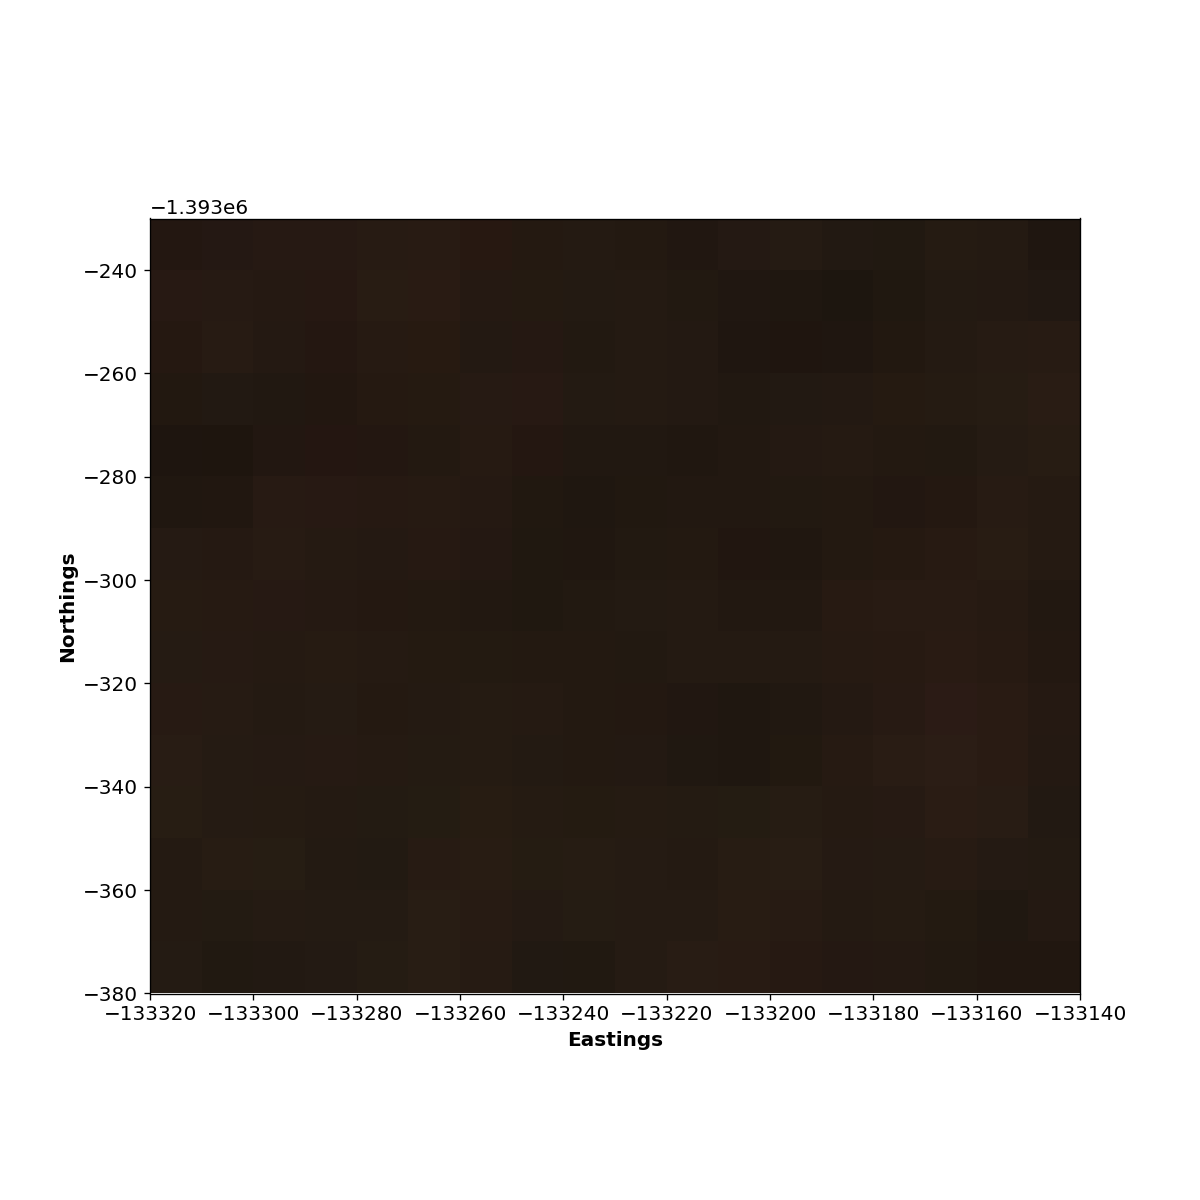

In [27]:
if field_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(ls_sat_array, output, field_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(s2_sat_array, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

<IPython.core.display.Javascript object>


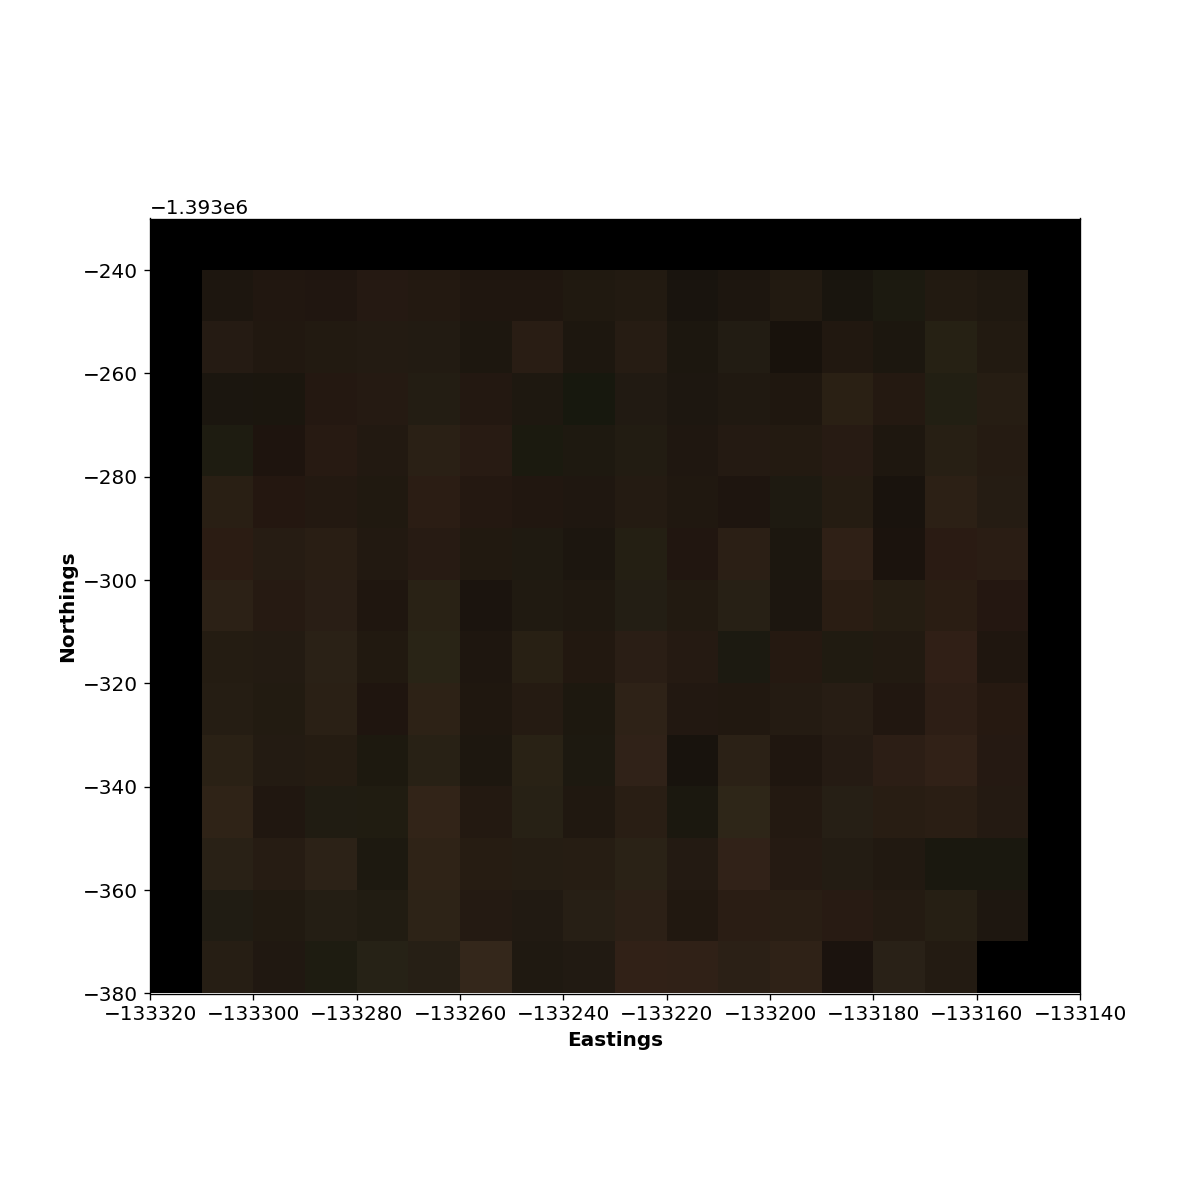

In [28]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, output, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_array, output, field_data, fignum)
fignum += 1

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min,max and mean variance. Variance is defined as the radio of standard
deviation, divided by the mean for each band. The variance should typically be less than 5%.

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


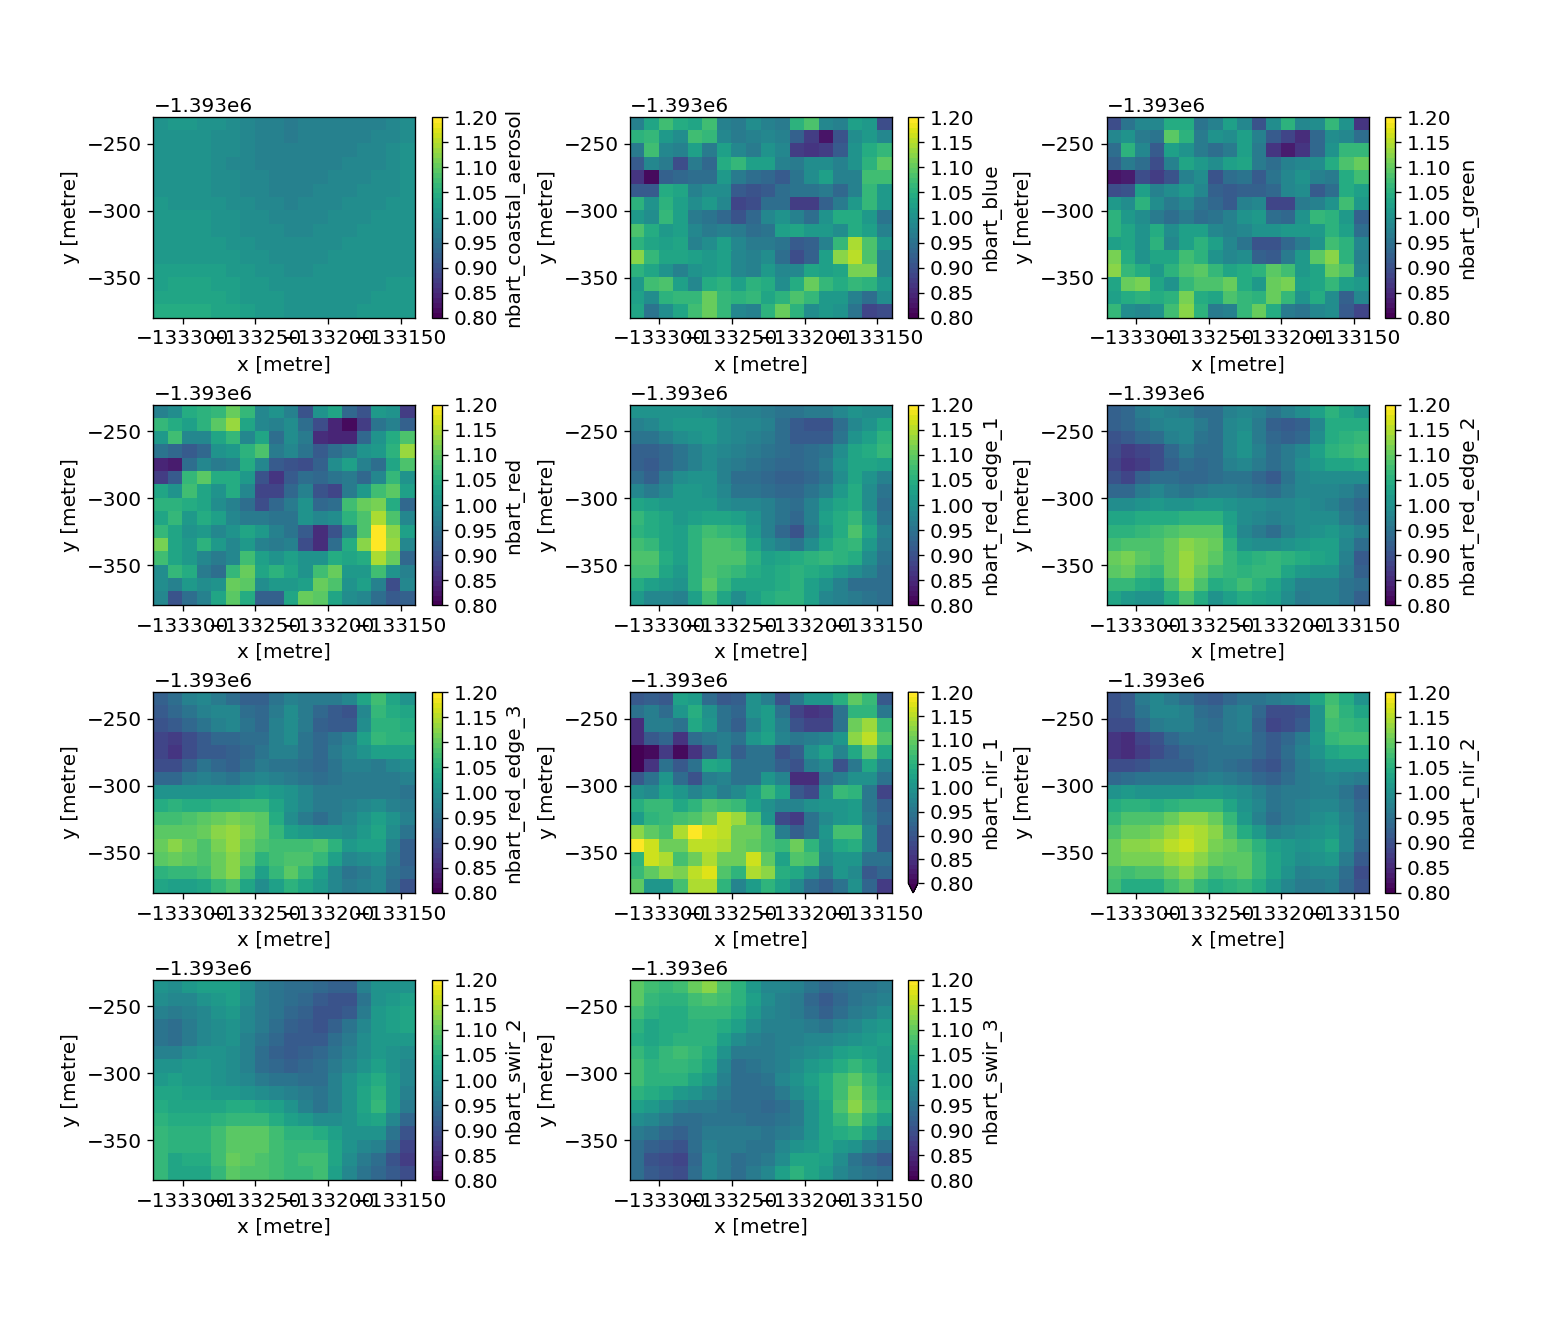

In [29]:
if field_data[3] == 'Landsat8':
    variance = FIG_SatBands.FIG_sat_bands(ls_sat_array, ls_field_WSarray, output, field_data, fignum)
else:
    variance = FIG_SatBands.FIG_sat_bands(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

<IPython.core.display.Javascript object>


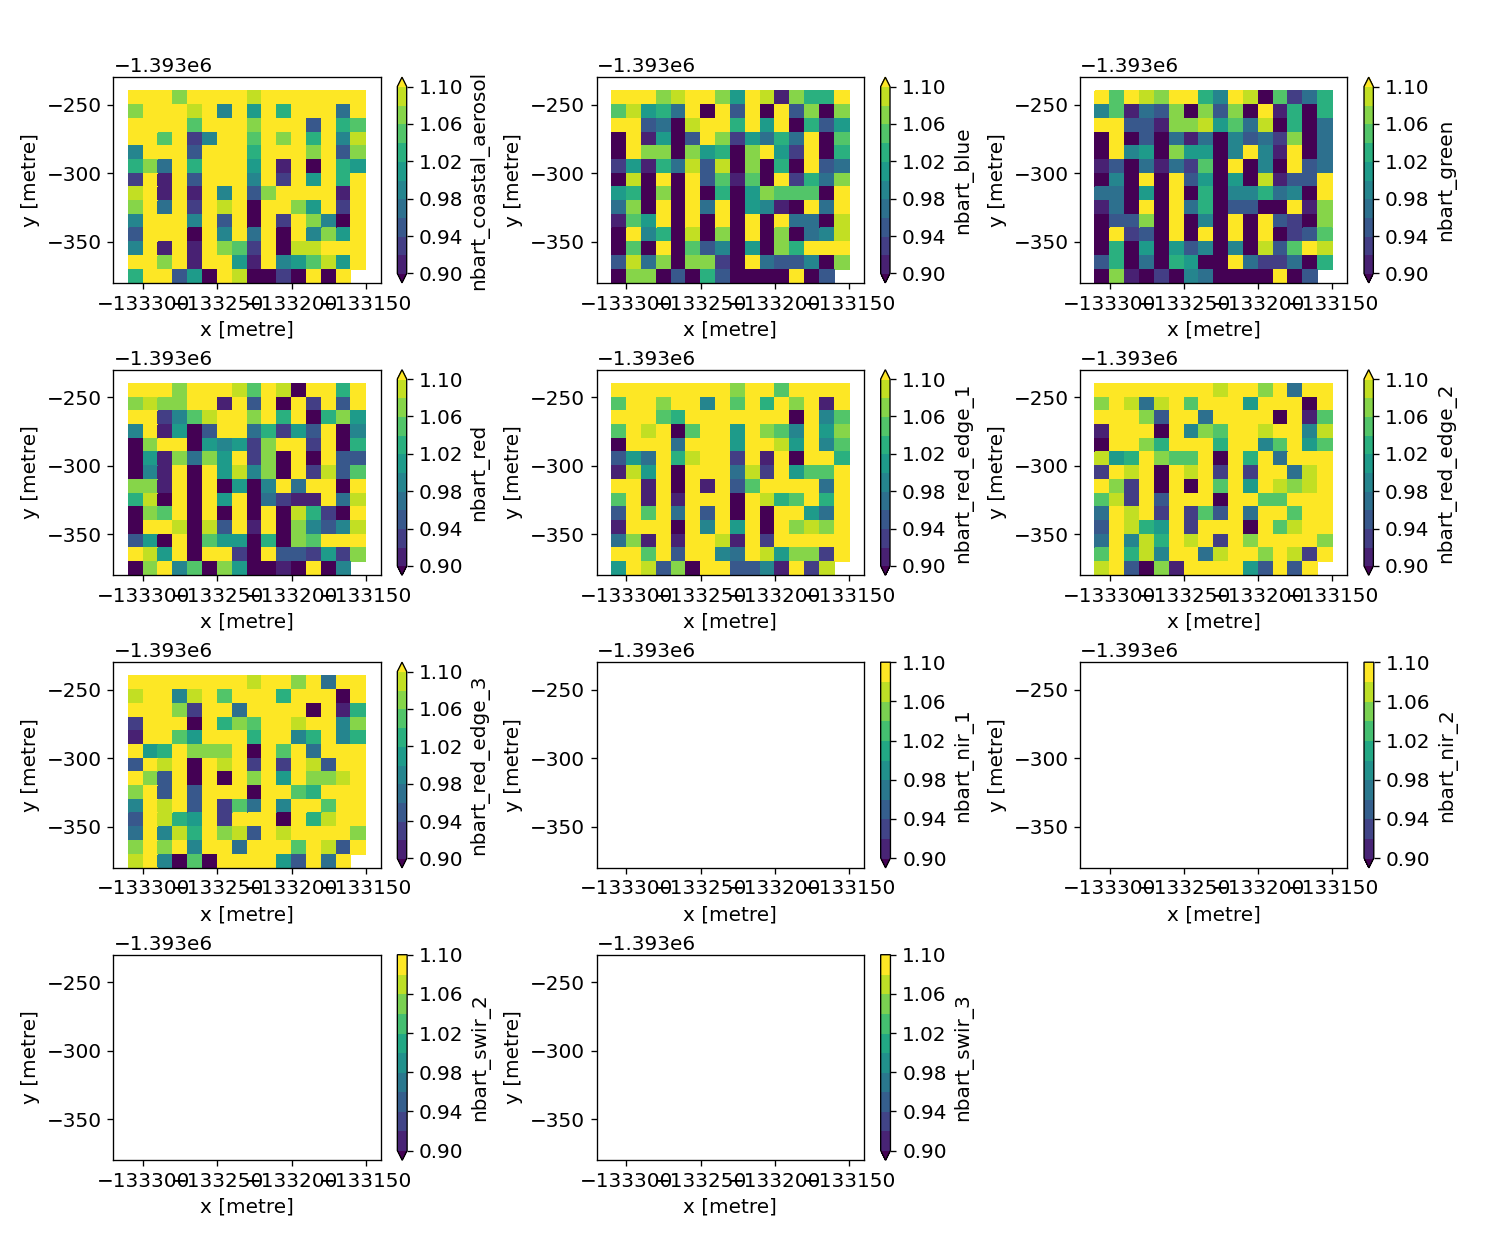

In [32]:
if field_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(ls_sat_array, ls_field_WSarray, output, field_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [33]:
ls_fstat_df, s2_fstat_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
ls_fstat_WSdf, dummy = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

if field_data[6] == 'USGS':
    ls_fstat_usgs_df, dummy = CreateStats.create_stats(ls8_usgs_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
else:
    ls_fstat_usgs_df = 0

## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [34]:
ls_finner_df, s2_finner_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_array, s2_field_array, ls_ground_brdf, s2_ground_brdf, ls_fstat_df, s2_fstat_df, field_data)
ls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_WSarray, s2_field_array, ls_ground_WSbrdf, s2_ground_brdf, ls_fstat_WSdf, s2_fstat_df, field_data)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

<IPython.core.display.Javascript object>


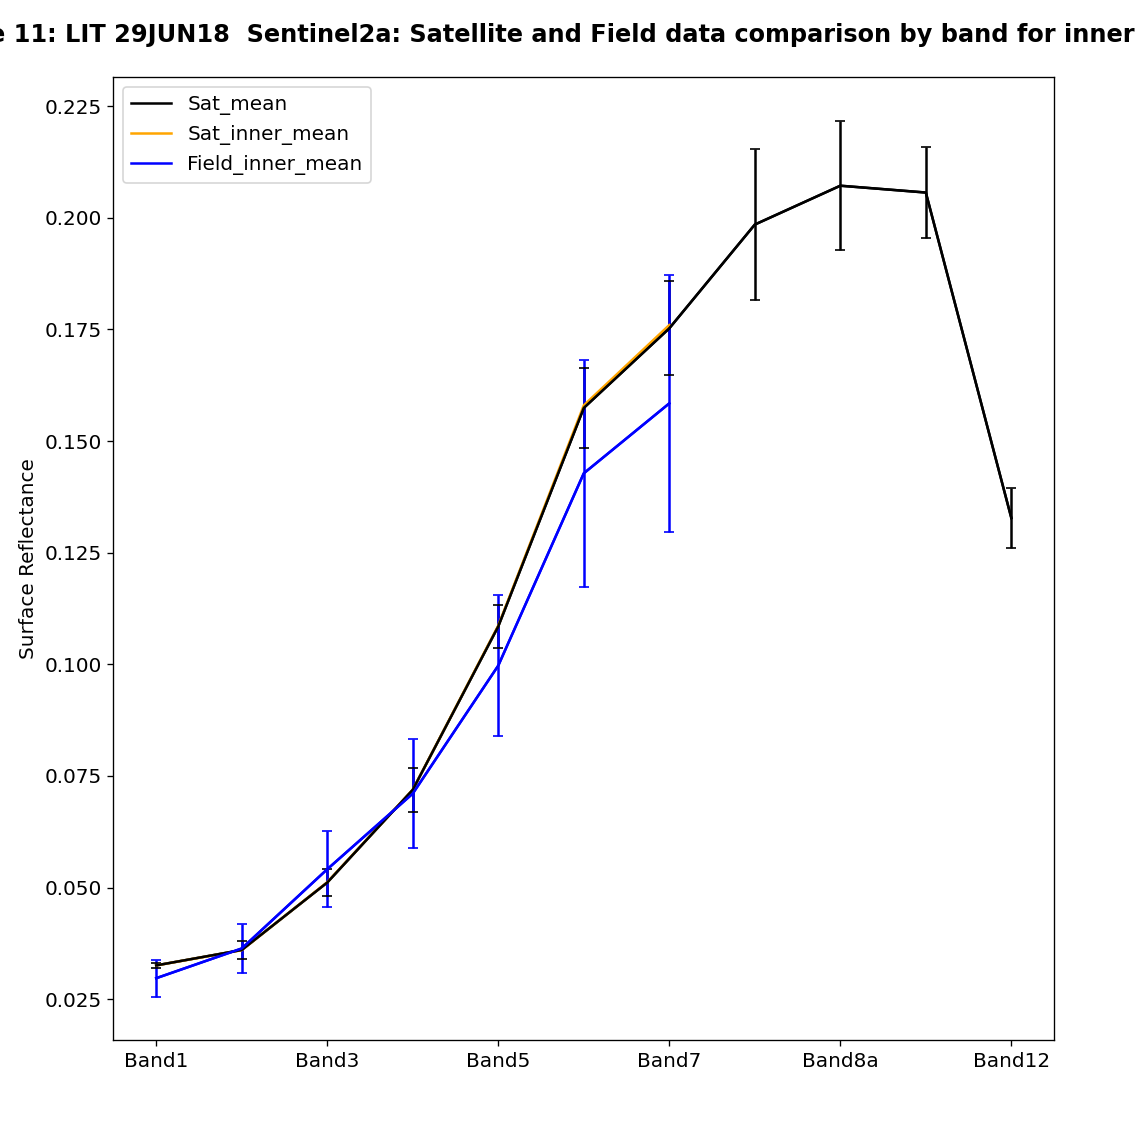

In [35]:
if field_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

<IPython.core.display.Javascript object>


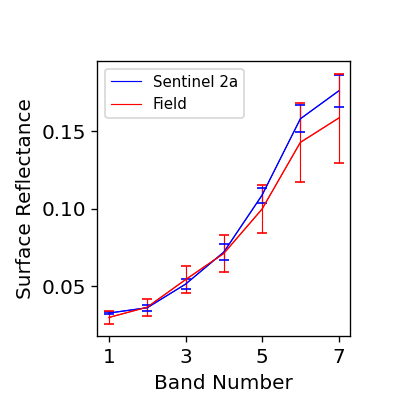

In [36]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

<IPython.core.display.Javascript object>


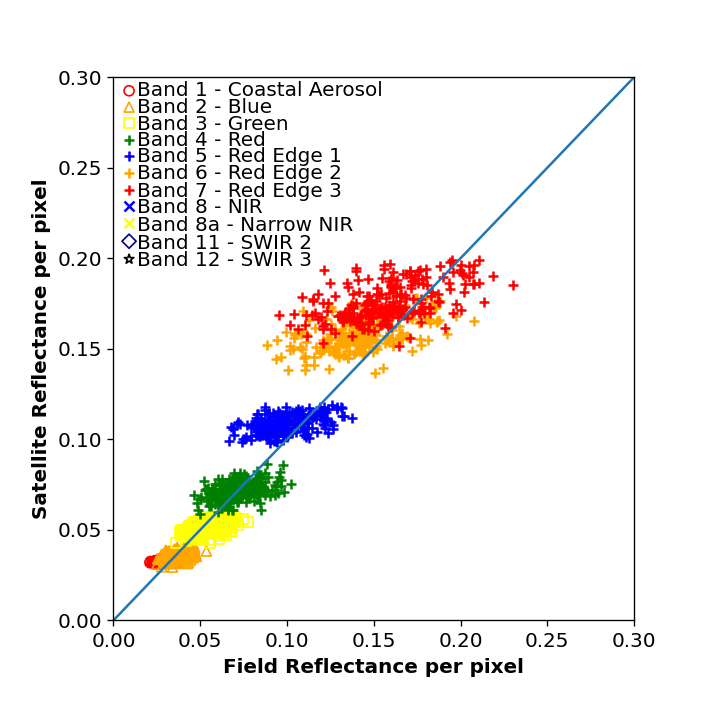

In [37]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, output, field_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(s2_sat_array, s2_field_array, plot_scale, output, field_data, fignum)
fignum += 1

<IPython.core.display.Javascript object>


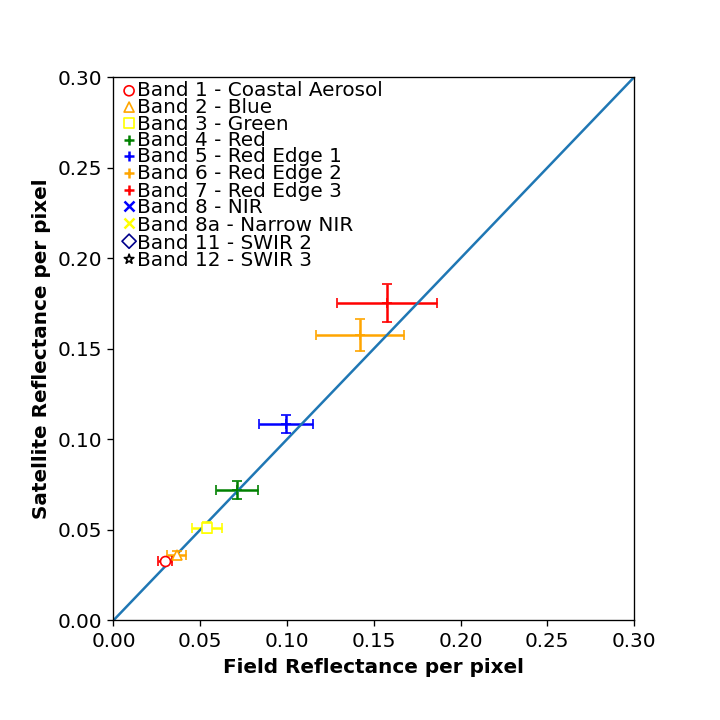

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [38]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, ls_fstat_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(s2_sat_array, s2_field_array, plot_scale, s2_fstat_df, output, field_data, fignum)
fignum += 1

In [39]:
if field_data[3] == 'Landsat8':
    PrintSheet.print_sheet(ls_ground_WSbrdf, ls_sat_array, ls_fstat_WSdf, indir, output, field_data, Corners, RockWalk, StartCorner, variance, ls_query, ls_dc)
else:
    PrintSheet.print_sheet(s2_ground_brdf, s2_sat_array, s2_fstat_df, indir, output, field_data, Corners, RockWalk, StartCorner, variance, s2_query, s2_dc)

TypeError: Timestamp subtraction must have the same timezones or no timezones

In [40]:
OutputCSVs.output_csvs(ls_fstat_WSdf, ls_fstat_usgs_df, s2_fstat_df, ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

TypeError: Timestamp subtraction must have the same timezones or no timezones

In [41]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:29:05 (h:m:s) to run


In [42]:
dee.median(axis=1).to_csv('../CSV/FULL_SPEC_AVG/'+field_data[0]+field_data[1]+'.csv')